In [ ]:
# --- LANGKAH 1: BERSIH-BERSIH & INSTALASI ---
import os
import shutil

# 1. Hubungkan Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Hapus cache lama agar tidak ada error sisa masa lalu
caches = [
    "/root/.cache/huggingface/datasets",
    "/content/batik-lora-model"
]
for c in caches:
    if os.path.exists(c):
        shutil.rmtree(c)
        print(f"Cache lama dibersihkan: {c}")

# 3. Install Library Versi Development (PENTING untuk menghindari error versi)
print("Sedang menginstall library... (tunggu sebentar)")
!pip install -q git+https://github.com/huggingface/diffusers.git
!pip install -q -U -r https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/requirements.txt
!pip install -q bitsandbytes
!pip install -q peft

print("✅ Instalasi Selesai.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sedang menginstall library... (tunggu sebentar)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Instalasi Selesai.


In [ ]:
# --- LANGKAH 2: CARI GAMBAR & BUAT METADATA ---
import os
import json

# Kita arahkan langsung ke folder induk BATIK
# Script akan mencari sampai ke dalam-dalam subfolder apapun yang ada
ROOT_DIR = "/content/drive/MyDrive/DATA_COLAB/BATIK"

print(f"🔍 Memindai folder: {ROOT_DIR}")

metadata = []
image_extensions = ('.png', '.jpg', '.jpeg', '.webp')
total_images = 0

# Loop mencari gambar
for root, dirs, files in os.walk(ROOT_DIR):
    # Abaikan folder sampah sistem
    if ".ipynb_checkpoints" in root:
        continue

    for filename in files:
        if filename.lower().endswith(image_extensions):
            # Path lengkap gambar
            full_path = os.path.join(root, filename)

            # Ambil nama folder sebagai label gaya (misal: folder 'batik-parang')
            folder_name = os.path.basename(root)

            # Buat caption otomatis: "gaya_batik_batik_parang"
            clean_folder_name = folder_name.replace(" ", "_").replace("-", "_")
            caption = f"batik_style_{clean_folder_name}"

            # Masukkan ke daftar
            # Kita pakai path relatif agar script training tidak bingung
            try:
                rel_path = os.path.relpath(full_path, ROOT_DIR)
                metadata.append({
                    "file_name": rel_path,
                    "text": caption
                })
                total_images += 1
            except Exception as e:
                print(f"Skip file error: {filename}")

# Simpan file metadata.jsonl di ROOT_DIR
if total_images > 0:
    metadata_path = os.path.join(ROOT_DIR, "metadata.jsonl")
    with open(metadata_path, 'w') as f:
        for entry in metadata:
            json.dump(entry, f)
            f.write('\n')

    print(f"✅ SUKSES! Ditemukan {total_images} gambar.")
    print(f"📄 File metadata dibuat di: {metadata_path}")
    print(f"📝 Contoh caption: {metadata[0]['text']}")
else:
    print("❌ ERROR: Tidak ada gambar ditemukan di folder BATIK. Cek lagi lokasi file Anda di Google Drive.")

🔍 Memindai folder: /content/drive/MyDrive/DATA_COLAB/BATIK
✅ SUKSES! Ditemukan 981 gambar.
📄 File metadata dibuat di: /content/drive/MyDrive/DATA_COLAB/BATIK/metadata.jsonl
📝 Contoh caption: batik_style_batik_bali


In [ ]:
import os
import json
from PIL import Image

ROOT_DIR = "/content/drive/MyDrive/DATA_COLAB/BATIK"
print(f"🔍 Memulai pemeriksaan kesehatan gambar di: {ROOT_DIR}")

bad_files_count = 0
total_images = 0
metadata = []
image_extensions = ('.png', '.jpg', '.jpeg', '.webp')

# 1. SCANNING DAN PEMBERSIHAN GAMBAR RUSAK
for root, dirs, files in os.walk(ROOT_DIR):
    # Abaikan folder hidden
    if ".ipynb_checkpoints" in root:
        continue

    for filename in files:
        if filename.lower().endswith(image_extensions):
            full_path = os.path.join(root, filename)

            # Cek apakah gambar bisa dibuka
            try:
                with Image.open(full_path) as img:
                    img.verify() # Verifikasi integritas file

                # Jika lolos verifikasi, masukkan ke metadata baru
                # Buat caption
                folder_name = os.path.basename(root)
                clean_folder_name = folder_name.replace(" ", "_").replace("-", "_")
                caption = f"gaya_batik_{clean_folder_name}"

                rel_path = os.path.relpath(full_path, ROOT_DIR)
                metadata.append({
                    "file_name": rel_path,
                    "text": caption
                })
                total_images += 1

            except Exception as e:
                print(f"❌ Ditemukan file RUSAK: {filename}")
                print(f"   Lokasi: {full_path}")
                print(f"   Error: {e}")
                try:
                    os.remove(full_path)
                    print("   🗑️ File berhasil dihapus.")
                    bad_files_count += 1
                except:
                    print("   ⚠️ Gagal menghapus file, harap hapus manual.")

print("-" * 30)
print(f"Pemeriksaan selesai.")
print(f"Total gambar sehat: {total_images}")
print(f"Total gambar rusak dihapus: {bad_files_count}")

# 2. UPDATE METADATA.JSONL (Penting!)
if total_images > 0:
    metadata_path = os.path.join(ROOT_DIR, "metadata.jsonl")
    with open(metadata_path, 'w') as f:
        for entry in metadata:
            json.dump(entry, f)
            f.write('\n')
    print(f"✅ File 'metadata.jsonl' berhasil diperbarui (bebas dari file rusak).")
else:
    print("❌ Tidak ada gambar tersisa. Cek dataset Anda.")

🔍 Memulai pemeriksaan kesehatan gambar di: /content/drive/MyDrive/DATA_COLAB/BATIK
------------------------------
Pemeriksaan selesai.
Total gambar sehat: 981
Total gambar rusak dihapus: 0
✅ File 'metadata.jsonl' berhasil diperbarui (bebas dari file rusak).


In [ ]:
# --- LANGKAH 3: MULAI TRAINING ---

# 1. Download Script Training Terbaru
!wget -q -nc https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py

# 2. Setting Lokasi
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
DATA_DIR = "/content/drive/MyDrive/DATA_COLAB/BATIK" # Folder data kita
OUTPUT_DIR = "/content/batik_lora_result" # Simpan di Colab dulu biar cepat

# 3. Perintah Training
# Kita pakai --caption_column="text" karena kita sudah buat metadata.jsonl di Cell 2
print("🚀 Memulai Training... (Biasanya butuh waktu 15-30 menit)")

!accelerate launch train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir="$DATA_DIR" \
  --caption_column="text" \
  --resolution=512 \
  --random_flip \
  --train_batch_size=4 \
  --num_train_epochs=10 \
  --checkpointing_steps=5000 \
  --learning_rate=1e-04 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --seed=42 \
  --output_dir=$OUTPUT_DIR \
  --rank=64

# 4. Simpan Hasil ke Drive
FINAL_SAVE_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"
if os.path.exists(os.path.join(OUTPUT_DIR, "pytorch_lora_weights.safetensors")) or os.path.exists(os.path.join(OUTPUT_DIR, "pytorch_lora_weights.bin")):
    print("✅ Training Selesai! Menyimpan model ke Google Drive...")
    !mkdir -p "$FINAL_SAVE_PATH"
    !cp -r $OUTPUT_DIR/* "$FINAL_SAVE_PATH"
    print(f"🎉 Model tersimpan aman di: {FINAL_SAVE_PATH}")
else:
    print("⚠️ Sepertinya training gagal. Cek pesan error di atas.")

🚀 Memulai Training... (Biasanya butuh waktu 15-30 menit)
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-11-25 01:37:01.213323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764034621.255048    6910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764034621.270066    6910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been register

Loading model...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


✅ Model LoRA berhasil dimuat!
Sedang membuat gambar dengan prompt: A futuristic hoodie with batik_style_parang pattern, high quality, 8k


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


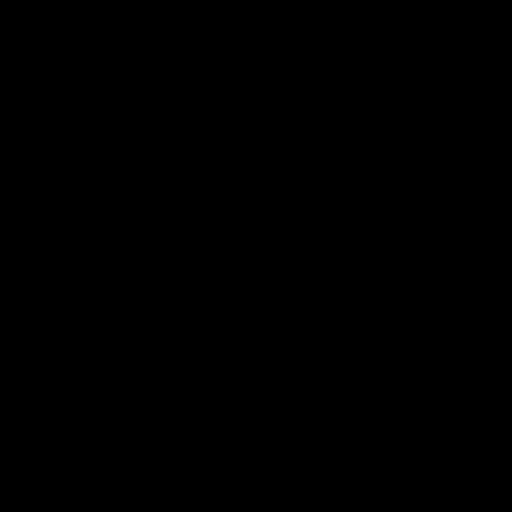

In [ ]:
# --- LANGKAH 4: TEST GENERATE GAMBAR ---
import torch
from diffusers import StableDiffusionPipeline

# Lokasi model yang baru dilatih
LORA_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"

print("Loading model...")
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.to("cuda")

# Load LoRA kita
try:
    pipe.load_lora_weights(LORA_PATH)
    print("✅ Model LoRA berhasil dimuat!")

    # Ganti 'gaya_batik_...' dengan salah satu nama folder batik Anda (misal: batik_parang)
    prompt = "A futuristic hoodie with batik_style_parang pattern, high quality, 8k"

    print(f"Sedang membuat gambar dengan prompt: {prompt}")
    image = pipe(prompt, num_inference_steps=30).images[0]
    display(image)

except Exception as e:
    print(f"Gagal memuat model: {e}")
    print("Pastikan training di langkah 3 sukses.")

Loading model base...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

✅ Model LoRA berhasil dimuat!
🎨 Generating dengan Scale: 0.7...


  0%|          | 0/40 [00:00<?, ?it/s]

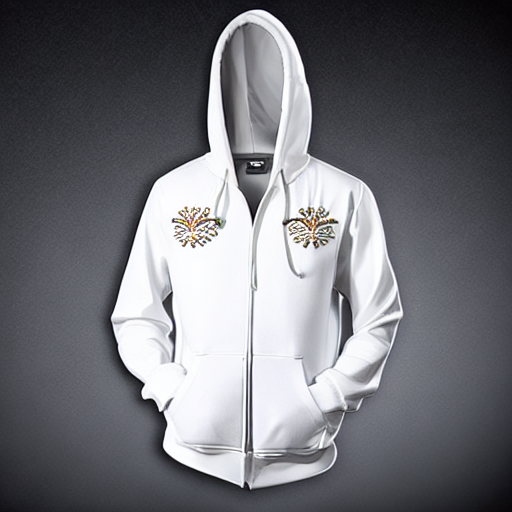

In [ ]:
# --- LANGKAH 4: TEST GENERATE GAMBAR (VERSI PERBAIKAN) ---
import torch
from diffusers import StableDiffusionPipeline

# Lokasi model
LORA_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"

print("Loading model base...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None # Mematikan safety checker agar tidak memblokir gambar aman
)
pipe.to("cuda")

# Load LoRA
try:
    pipe.load_lora_weights(LORA_PATH)
    print("✅ Model LoRA berhasil dimuat!")

    # --- SETTING PENTING UNTUK MENGATASI GAMBAR RUSAK ---

    # 1. Tentukan Skala (Kekuatan) LoRA
    # 1.0 = Full power (Sering bikin gambar rusak/fried)
    # 0.6 - 0.8 = Sweet spot (Biasanya paling bagus, motif dapat tapi objek tetap jelas)
    # 0.4 - 0.5 = Tipis-tipis
    LORA_SCALE = 0.7

    # 2. Prompt yang lebih deskriptif
    # Tambahkan "realistic, photo of..." agar model tahu ini benda nyata, bukan tekstur wallpaper
    prompt = "A realistic photo of a futuristic hoodie jacket, wearing by a mannequin, white background, studio lighting, texture with gaya_batik_batik_parang pattern, high quality, 8k, uhd"

    # 3. Negative Prompt (Wajib ada untuk SD 1.5)
    # Ini memberitahu model apa yang JANGAN dibuat
    neg_prompt = "abstract, chaotic, messy, texture only, full pattern, noise, blurry, distorted, ugly, bad anatomy, low quality, pixelated"

    print(f"🎨 Generating dengan Scale: {LORA_SCALE}...")

    # Generate dengan cross_attention_kwargs untuk mengatur kekuatan LoRA
    image = pipe(
        prompt,
        negative_prompt=neg_prompt,
        num_inference_steps=40,         # Langkah diperbanyak sedikit biar detail
        guidance_scale=7.5,             # Seberapa patuh pada prompt
        cross_attention_kwargs={"scale": LORA_SCALE} # <--- KUNCI PERBAIKANNYA DISINI
    ).images[0]

    display(image)

    # Tips: Jika motif batiknya kurang terlihat, naikkan LORA_SCALE ke 0.8 atau 0.9
    # Tips: Jika gambar masih hancur/abstrak, turunkan LORA_SCALE ke 0.5 atau 0.6

except Exception as e:
    print(f"Error: {e}")

Loading model base...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

✅ Model LoRA berhasil dimuat!
🎨 Generating dengan Scale: 0.8...


  0%|          | 0/40 [00:00<?, ?it/s]

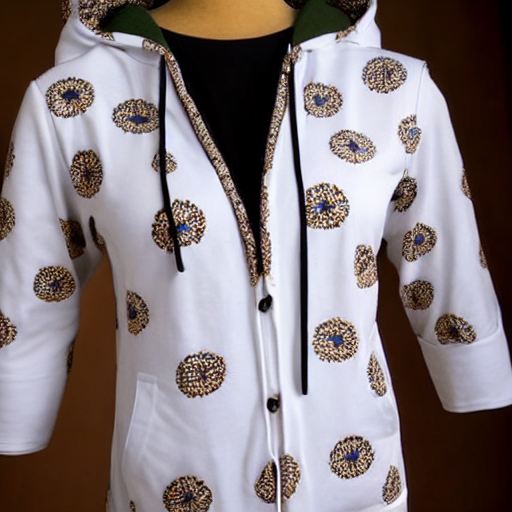

In [ ]:
# --- LANGKAH 4: TEST GENERATE GAMBAR (VERSI PERBAIKAN) ---
import torch
from diffusers import StableDiffusionPipeline

# Lokasi model
LORA_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"

print("Loading model base...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None # Mematikan safety checker agar tidak memblokir gambar aman
)
pipe.to("cuda")

# Load LoRA
try:
    pipe.load_lora_weights(LORA_PATH)
    print("✅ Model LoRA berhasil dimuat!")

    # --- SETTING PENTING UNTUK MENGATASI GAMBAR RUSAK ---

    # 1. Tentukan Skala (Kekuatan) LoRA
    # 1.0 = Full power (Sering bikin gambar rusak/fried)
    # 0.6 - 0.8 = Sweet spot (Biasanya paling bagus, motif dapat tapi objek tetap jelas)
    # 0.4 - 0.5 = Tipis-tipis
    LORA_SCALE = 0.8

    # 2. Prompt yang lebih deskriptif
    # Tambahkan "realistic, photo of..." agar model tahu ini benda nyata, bukan tekstur wallpaper
    prompt = "A realistic photo of a hoodie jacket of batik megamendung, wearing by a mannequin, white background, studio lighting, texture with gaya_batik_batik_parang pattern, high quality, 8k, uhd"

    # 3. Negative Prompt (Wajib ada untuk SD 1.5)
    # Ini memberitahu model apa yang JANGAN dibuat
    neg_prompt = "abstract, chaotic, messy, texture only, full pattern, noise, blurry, distorted, ugly, bad anatomy, low quality, pixelated"

    print(f"🎨 Generating dengan Scale: {LORA_SCALE}...")

    # Generate dengan cross_attention_kwargs untuk mengatur kekuatan LoRA
    image = pipe(
        prompt,
        negative_prompt=neg_prompt,
        num_inference_steps=40,         # Langkah diperbanyak sedikit biar detail
        guidance_scale=7.5,             # Seberapa patuh pada prompt
        cross_attention_kwargs={"scale": LORA_SCALE} # <--- KUNCI PERBAIKANNYA DISINI
    ).images[0]

    display(image)

    # Tips: Jika motif batiknya kurang terlihat, naikkan LORA_SCALE ke 0.8 atau 0.9
    # Tips: Jika gambar masih hancur/abstrak, turunkan LORA_SCALE ke 0.5 atau 0.6

except Exception as e:
    print(f"Error: {e}")

Loading model base...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

✅ Model LoRA berhasil dimuat!
🎨 Generating dengan Scale: 0.8...


  0%|          | 0/40 [00:00<?, ?it/s]

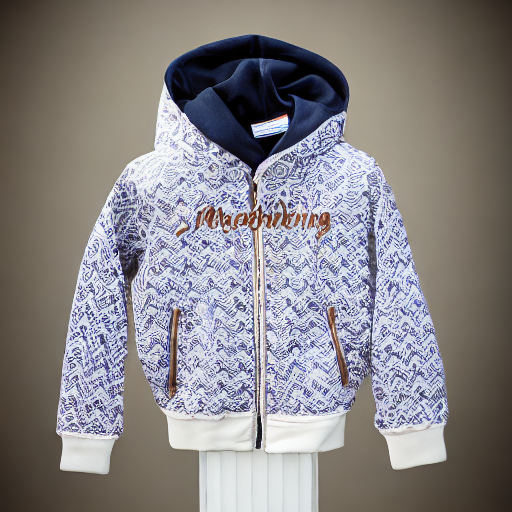

In [ ]:
# --- LANGKAH 4: TEST GENERATE GAMBAR (VERSI PERBAIKAN) ---
import torch
from diffusers import StableDiffusionPipeline

# Lokasi model
LORA_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"

print("Loading model base...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None # Mematikan safety checker agar tidak memblokir gambar aman
)
pipe.to("cuda")

# Load LoRA
try:
    pipe.load_lora_weights(LORA_PATH)
    print("✅ Model LoRA berhasil dimuat!")

    # --- SETTING PENTING UNTUK MENGATASI GAMBAR RUSAK ---

    # 1. Tentukan Skala (Kekuatan) LoRA
    # 1.0 = Full power (Sering bikin gambar rusak/fried)
    # 0.6 - 0.8 = Sweet spot (Biasanya paling bagus, motif dapat tapi objek tetap jelas)
    # 0.4 - 0.5 = Tipis-tipis
    LORA_SCALE = 0.8

    # 2. Prompt yang lebih deskriptif
    # Tambahkan "realistic, photo of..." agar model tahu ini benda nyata, bukan tekstur wallpaper
    prompt = "A realistic photo of a hoodie jacket of gaya_batik_megamendung, wearing by a mannequin, white background, studio lighting, texture with gaya_batik_batik_parang pattern, high quality, 8k, uhd"

    # 3. Negative Prompt (Wajib ada untuk SD 1.5)
    # Ini memberitahu model apa yang JANGAN dibuat
    neg_prompt = "abstract, chaotic, messy, texture only, full pattern, noise, blurry, distorted, ugly, bad anatomy, low quality, pixelated"

    print(f"🎨 Generating dengan Scale: {LORA_SCALE}...")

    # Generate dengan cross_attention_kwargs untuk mengatur kekuatan LoRA
    image = pipe(
        prompt,
        negative_prompt=neg_prompt,
        num_inference_steps=40,         # Langkah diperbanyak sedikit biar detail
        guidance_scale=7.5,             # Seberapa patuh pada prompt
        cross_attention_kwargs={"scale": LORA_SCALE} # <--- KUNCI PERBAIKANNYA DISINI
    ).images[0]

    display(image)

    # Tips: Jika motif batiknya kurang terlihat, naikkan LORA_SCALE ke 0.8 atau 0.9
    # Tips: Jika gambar masih hancur/abstrak, turunkan LORA_SCALE ke 0.5 atau 0.6

except Exception as e:
    print(f"Error: {e}")

Loading model base...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

✅ Model LoRA berhasil dimuat!
🎨 Generating dengan Scale: 0.8...


  0%|          | 0/40 [00:00<?, ?it/s]

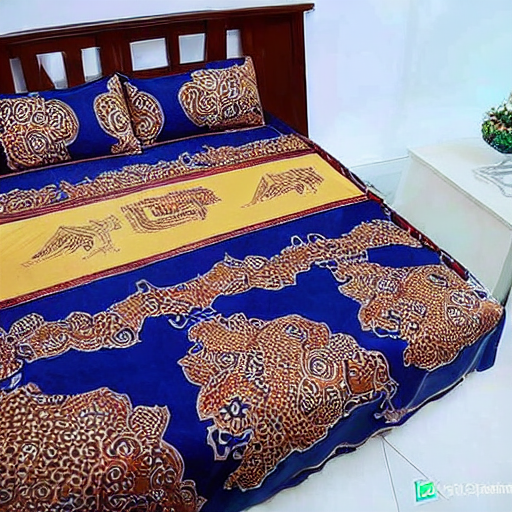

In [ ]:
# --- LANGKAH 4: TEST GENERATE GAMBAR (VERSI PERBAIKAN) ---
import torch
from diffusers import StableDiffusionPipeline

# Lokasi model
LORA_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"

print("Loading model base...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None # Mematikan safety checker agar tidak memblokir gambar aman
)
pipe.to("cuda")

# Load LoRA
try:
    pipe.load_lora_weights(LORA_PATH)
    print("✅ Model LoRA berhasil dimuat!")

    # --- SETTING PENTING UNTUK MENGATASI GAMBAR RUSAK ---

    # 1. Tentukan Skala (Kekuatan) LoRA
    # 1.0 = Full power (Sering bikin gambar rusak/fried)
    # 0.6 - 0.8 = Sweet spot (Biasanya paling bagus, motif dapat tapi objek tetap jelas)
    # 0.4 - 0.5 = Tipis-tipis
    LORA_SCALE = 0.8

    # 2. Prompt yang lebih deskriptif
    # Tambahkan "realistic, photo of..." agar model tahu ini benda nyata, bukan tekstur wallpaper
    prompt = "batik_style_megamendung sheet"

    # 3. Negative Prompt (Wajib ada untuk SD 1.5)
    # Ini memberitahu model apa yang JANGAN dibuat
    neg_prompt = " full pattern, noise, blurry, distorted"

    print(f"🎨 Generating dengan Scale: {LORA_SCALE}...")

    # Generate dengan cross_attention_kwargs untuk mengatur kekuatan LoRA
    image = pipe(
        prompt,
        negative_prompt=neg_prompt,
        num_inference_steps=40,         # Langkah diperbanyak sedikit biar detail
        guidance_scale=7.5,             # Seberapa patuh pada prompt
        cross_attention_kwargs={"scale": LORA_SCALE} # <--- KUNCI PERBAIKANNYA DISINI
    ).images[0]

    display(image)

    # Tips: Jika motif batiknya kurang terlihat, naikkan LORA_SCALE ke 0.8 atau 0.9
    # Tips: Jika gambar masih hancur/abstrak, turunkan LORA_SCALE ke 0.5 atau 0.6

except Exception as e:
    print(f"Error: {e}")

In [ ]:
# --- LANGKAH 4: TEST GENERATE GAMBAR (VERSI PERBAIKAN) ---
import torch
from diffusers import StableDiffusionPipeline

# Lokasi model
LORA_PATH = "/content/drive/MyDrive/DATA_COLAB/HASIL_MODEL_BATIK2"

print("Loading model base...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None # Mematikan safety checker agar tidak memblokir gambar aman
)
pipe.to("cuda")

# Load LoRA
try:
    pipe.load_lora_weights(LORA_PATH)
    print("✅ Model LoRA berhasil dimuat!")

    # --- SETTING PENTING UNTUK MENGATASI GAMBAR RUSAK ---

    # 1. Tentukan Skala (Kekuatan) LoRA
    # 1.0 = Full power (Sering bikin gambar rusak/fried)
    # 0.6 - 0.8 = Sweet spot (Biasanya paling bagus, motif dapat tapi objek tetap jelas)
    # 0.4 - 0.5 = Tipis-tipis
    LORA_SCALE = 0.8

    # 2. Prompt yang lebih deskriptif
    # Tambahkan "realistic, photo of..." agar model tahu ini benda nyata, bukan tekstur wallpaper
    prompt = "batik_style_megamendung picture, 8k"

    # 3. Negative Prompt (Wajib ada untuk SD 1.5)
    # Ini memberitahu model apa yang JANGAN dibuat
    neg_prompt = " full pattern, noise, blurry, distorted"

    print(f"🎨 Generating dengan Scale: {LORA_SCALE}...")

    # Generate dengan cross_attention_kwargs untuk mengatur kekuatan LoRA
    image = pipe(
        prompt,
        negative_prompt=neg_prompt,
        num_inference_steps=40,         # Langkah diperbanyak sedikit biar detail
        guidance_scale=7.5,             # Seberapa patuh pada prompt
        cross_attention_kwargs={"scale": LORA_SCALE} # <--- KUNCI PERBAIKANNYA DISINI
    ).images[0]

    display(image)

    # Tips: Jika motif batiknya kurang terlihat, naikkan LORA_SCALE ke 0.8 atau 0.9
    # Tips: Jika gambar masih hancur/abstrak, turunkan LORA_SCALE ke 0.5 atau 0.6

except Exception as e:
    print(f"Error: {e}")